In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [16]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")

vueltas.drop(['Piloto'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020])]
vueltas_validation = vueltas[vueltas['anyo'].isin([2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2021]

#vueltas_test = vueltas_test[vueltas_test['Piloto'] == "alonso"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_validation = vueltas_validation.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)

#vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
#vueltas_test.drop(['Piloto'], axis = 1, inplace = True)


vueltas_train = vueltas_train.astype(float)
vueltas_validation = vueltas_validation.astype(float)
vueltas_test = vueltas_test.astype(float)

In [17]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)
vueltas_validation_scaler = scaler.transform(vueltas_validation)

In [18]:
trainX = []
trainY = []
testX = []
testY = []
validationX = []
validationY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])
    
for i in range (loopback, len(vueltas_validation_scaler) -future +1):
    validationX.append(vueltas_validation_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    validationY.append(vueltas_validation_scaler[i + future - 1:i + future,5])


In [19]:
trainX, trainY, testX, testY, validationX, validationY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY), np.array(validationX), np.array(validationY)





In [20]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 256)           283648    
                                                                 
 dropout_2 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 480,897
Trainable params: 480,897
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
48/48 [==============================] - 4s 40ms/step - loss: 0.0354
Epoch 2/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0153
Epoch 3/12
48/48 [==============================] - 2s 41ms/step - loss: 0.0118
Epoch 4/12
48/48 [==============================] - 2s 42ms/step - loss: 0.0113
Epoch 5/12
48/48 [==============================] - 2s 41ms/step - loss: 0.0098
Epoch 6/12
48/48 [==============================] - 2s 42ms/step - loss: 0.0092
Epoch 7/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0094
Epoch 8/12
48/48 [==============================] - 2s 42ms/step - loss: 0.0084
Epoch 9/12
48/48 [==============================] - 2s 41ms/step - loss: 0.0085
Epoch 10/12
48/48 [==============================] - 2s 41ms/step - loss: 0.0085
Epoch 11/12
48/48 [==============================] - 2s 40ms/step - loss: 0.0083
Epoch 12/12
48/48 [==============================] - 2s 47ms/step - loss: 0.0077


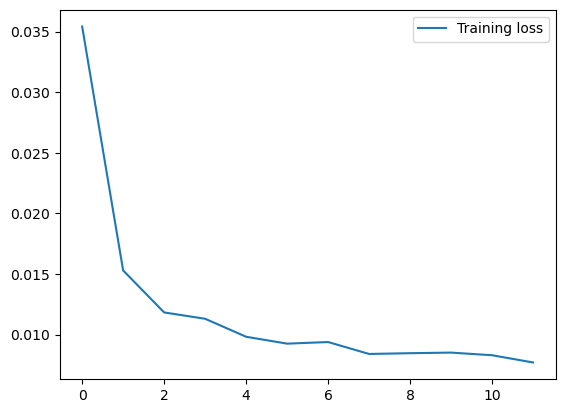

In [21]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [26]:
clases = np.unique(trainY[:,0])
clases

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [27]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(validationY[:,0])

In [28]:
#AQUI ES CON LOS DATOS DE VALIDADACION
predictions = model.predict(validationX)

32/32 [==============================] - 0s 9ms/step


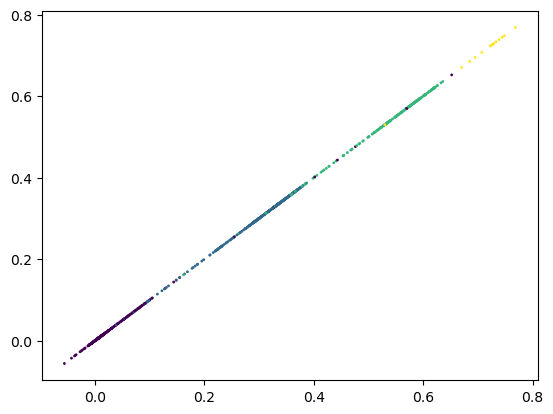

In [29]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [172]:
y_real_train = f(trainY[:,0])

In [37]:
predictions_test = model.predict(testX)

32/32 [==============================] - 0s 9ms/step


In [38]:
y_real_test =  f(testY[:,0])

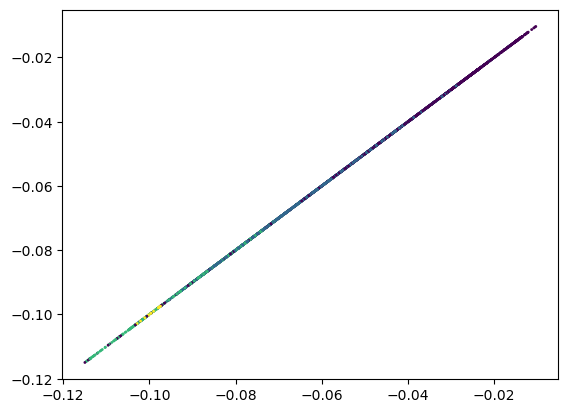

In [174]:

plt.scatter(predictions_train[:,0], predictions_train[:,0], s=1, c=y_real_train+1)

In [175]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [30]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(predictions, y_real) # Esto es de validacion

In [39]:
pred_test_2 = rl.predict(predictions_test)

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_real_test, pred_test_2))
print(classification_report(y_real_test, pred_test_2))

[[348   5  10   0]
 [ 21 407   0   0]
 [  0  37 181   0]
 [  0   0   1  14]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       363
           1       0.91      0.95      0.93       428
           2       0.94      0.83      0.88       218
           3       1.00      0.93      0.97        15

    accuracy                           0.93      1024
   macro avg       0.95      0.92      0.93      1024
weighted avg       0.93      0.93      0.93      1024

